In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the necessary packages/libraries
import os
import cv2
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import pathlib
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [3]:
# Setting random seed to value of 42
random.seed(42)

In [4]:
# Loading the numpy files of images and labels 
X = np.load('Breast_Cancer_imgs.npy') 
Y = np.load('Breast_Cancer_labels.npy') 

# No. of pixels for row and column size(square matrix)
m = 299

# Class Labels
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']

n_classes = len(classes)

In [5]:
# Image dataset dimensions
X.shape

(800, 299, 299, 3)

In [6]:
# Labels dimension
Y.shape

(800,)

In [7]:
# Splitting for training dataset and putting 20% to test dataset
from sklearn.model_selection import train_test_split
X_train, tmpx, y_train, tmpy = train_test_split(X, Y, test_size = 0.4)
X_test, X_val, y_test, y_val = train_test_split(tmpx, tmpy, test_size = 0.5)

In [8]:
# Own function to obtain random images and plot them
def Random_example_img(X, Y, x=4, y=5):
    fig = plt.figure(figsize = (21,17))
    fig.suptitle("Random Examples from Training Dataset", fontsize = 28)
    for i in range(x*y):
        plt.subplot(x,y,i+1)
        plt.xticks([])
        plt.yticks([])
        rand = random.randint(0,int(len(X)/2))
        plt.imshow(X[rand])
        plt.xlabel(classes[int(Y[rand])], fontsize=18)
    plt.show()

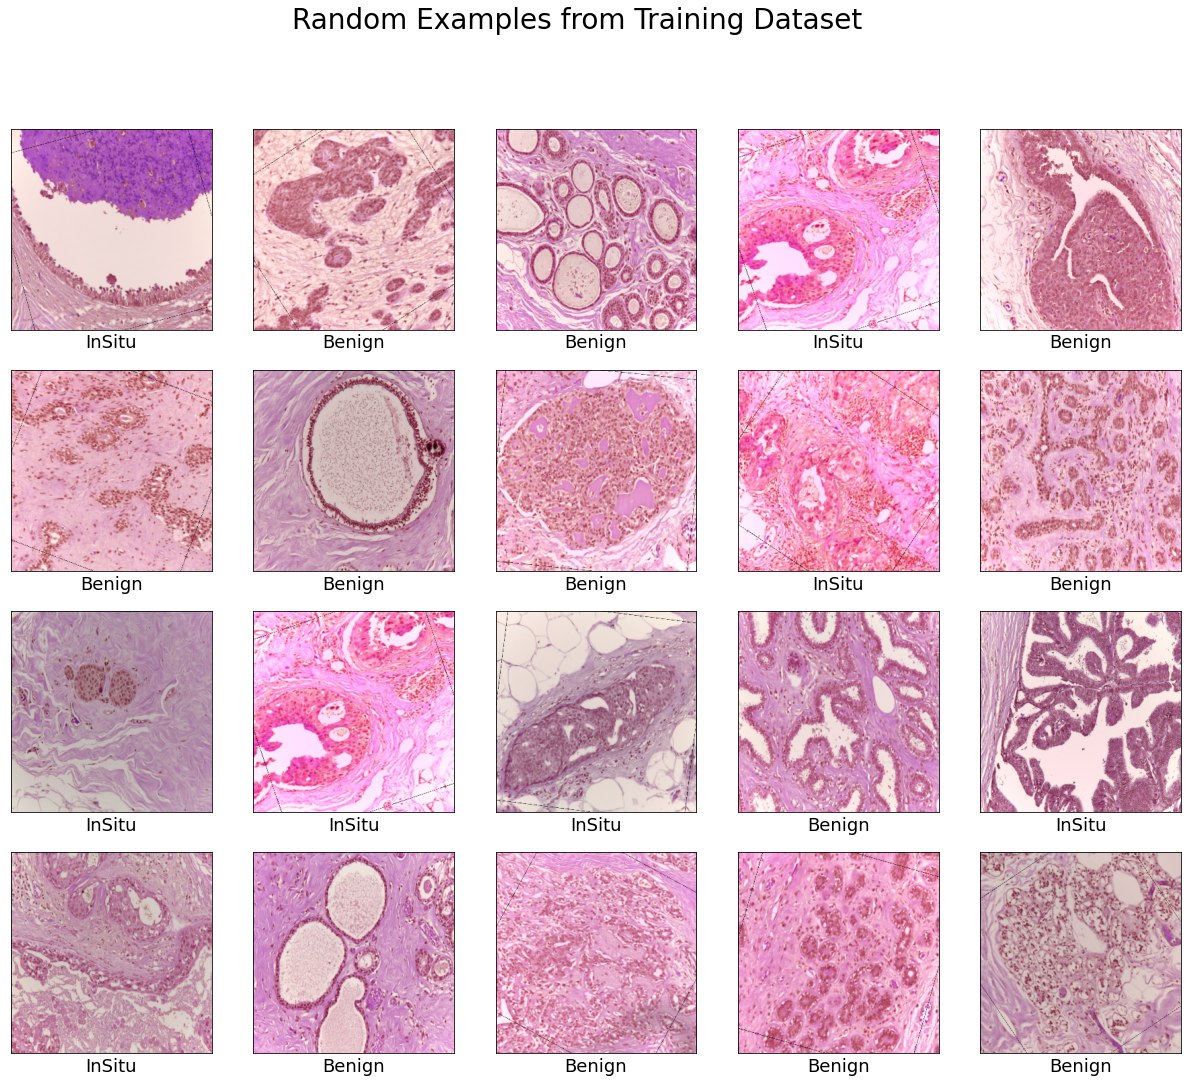

In [9]:
# Plotting random example images
Random_example_img(X, Y)

In [10]:
# Creating Xception model with pre-trained Imagenet weights followed by 3 layers and the output layer.
model = keras.models.Sequential([
    keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='max',input_shape = X_train[0].shape),
    keras.layers.BatchNormalization(),   
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.2),  
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(n_classes, activation = 'softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0 

In [11]:
# Early stopping and call backs to avoid over fitting of the model.
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='val_loss', patience = 25, verbose = 1, mode = 'min')
mcp_save = ModelCheckpoint('.mdl_wtsPL.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss', mode = 'min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, verbose=1, mode = 'min')

In [12]:
# Setting epochs to 100
set_epoch = 100
# Setting batch size to 15
batch = 15
# Training model
history = model.fit(X_train, y_train, epochs = set_epoch, batch_size = batch, validation_data = (X_val, y_val), 
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss], shuffle = True)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.3763 - accuracy: 0.3792
Epoch 1: val_loss improved from inf to 2.06565, saving model to .mdl_wtsPL.hdf5
32/32 [==============================] - 65s 1s/step - loss: 1.3763 - accuracy: 0.3792 - val_loss: 2.0657 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.1135 - accuracy: 0.4854
Epoch 2: val_loss improved from 2.06565 to 1.93498, saving model to .mdl_wtsPL.hdf5
32/32 [==============================] - 41s 1s/step - loss: 1.1135 - accuracy: 0.4854 - val_loss: 1.9350 - val_accuracy: 0.1937 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.9690 - accuracy: 0.5938
Epoch 3: val_loss improved from 1.93498 to 1.49743, saving model to .mdl_wtsPL.hdf5
32/32 [==============================] - 41s 1s/step - loss: 0.9690 - accuracy: 0.5938 - val_loss: 1.4974 - val_accuracy: 0.3938 - lr: 0.0010
Epoch 4/100
32/32 [======================

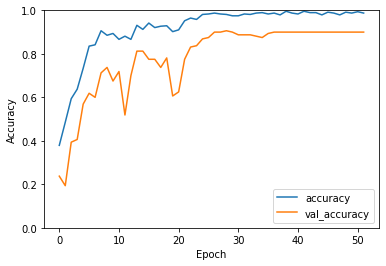

In [13]:
# Plotting of accuracy and validation-accuracy vs epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [14]:
# Evaluation of the model
test_loss, test_acc = model.evaluate(X_test, y_test)

5/5 [==============================] - 5s 505ms/step - loss: 0.2877 - accuracy: 0.9250


In [15]:
# Obtaining the predictions
pred = model.predict(X_test)

In [16]:
# Class-wise precision, recall and f1-score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_test, np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        38
           1       0.95      0.90      0.92        40
           2       0.93      0.95      0.94        39
           3       0.95      0.98      0.97        43

    accuracy                           0.93       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.93      0.93      0.92       160



In [17]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, normalize = False, title = None, cmap = plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes,
           title = title, ylabel = 'True label', xlabel = 'Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center", color = "white" 
                    if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

Confusion matrix, without normalization


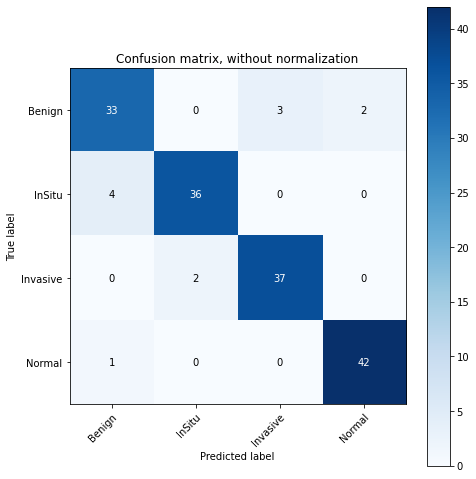

In [18]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_test, np.argmax(pred,axis = 1), classes = classes,title = 'Confusion matrix, without normalization')